# MLP 예측
1. Preprocessing
2. 분석 모델링
    - f1 score 계산
3. 예측 데이터 셋 도출

In [ ]:
# 1. 패키지 import
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint


import os

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yoonskyu","key":"d0dd946765ccff6f96ebaafcb8b36aa3"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle competitions download -c kakr-4th-competition
# !kaggle datasets list

  0% 0.00/683k [00:00<?, ?B/s]
100% 683k/683k [00:00<00:00, 45.2MB/s]
  0% 0.00/399k [00:00<?, ?B/s]
100% 399k/399k [00:00<00:00, 73.9MB/s]
  0% 0.00/43.4k [00:00<?, ?B/s]
100% 43.4k/43.4k [00:00<00:00, 14.0MB/s]


In [ ]:
!ls
!unzip train.csv.zip

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               


In [158]:
# 2. 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [159]:
# 3. Preprocessing

# 1) column 제거
def col_reduction(df):
    df.drop(['id','fnlwgt','education','relationship','native_country','workclass'], axis=1, inplace=True)
    
    return df

# 2) marital_status 조정
def mar_st(df):
    df['marital_status'] = (df['marital_status'] == 'Married-civ-spouse').astype(int)
    
    return df

# 3) race 조정
def race(df):
    df['race'] = ((train['race'] == 'White') | (train['race'] == 'Asian-Pac-Islander')).astype(int)

    return df

# 4) capital_gain, loss 조정
def capital(df):
    df['cap_gain_high'] = (df['capital_gain'] != 0).astype(int)
    df['cap_loss_high'] = (df['capital_loss'] >= 1700).astype(int)
    df['capital_gain'] = df['capital_gain'].map(lambda x : np.log(x) if x != 0 else 0)
    
    return df

# 5) age 조정 함수
def age(df):
    df.loc[df['age'] < 20, 'age_range'] = '~20'
    df.loc[df['age'] >= 65, 'age_range'] = '~65'

    down = 20
    for i in range(45//5):
        df.loc[(df['age'] >= down) & (df['age'] < down+5), 'age_range'] = str(down)+'~'+str(down+5)
        down += 5

    df['age'] = df['age_range']
    df.drop(['age_range'], axis=1, inplace=True)
    
    return df
    
# 6) One-hot encoding은 만들지 않았다.

# 7) edu_num 새 변수 만들기
def edu(df):
    df['edu_num_high'] = (df['education_num'] >= 13).astype(int)
    
    return df

# 8) hpw 새 변수 만들기
    
def hpw(df):
    df['hpw_high'] = (df['hours_per_week'] >= 50).astype(int)

    return df

# 9) MinMaxScaler
def mm_feature(df, feature):
    mm_scaler = MinMaxScaler()
    
    df[feature] = mm_scaler.fit_transform(df[feature].values.reshape(-1,1))
    
    return df, mm_scaler

# 10) target 분리: train은 하고, test는 안하므로 따로 만들겠다.
def target_handle(df):
    df['income'] = df['income_>50K']
    df.drop(['income_>50K','income_<=50K'], axis=1, inplace=True)
    
    y_df = df.income
    X_df = df.drop(['income'], axis=1, inplace=False)
    
    return X_df, y_df

def main(df):
    
    df1 = col_reduction(df)
    df2 = mar_st(df1)
    df3 = race(df2)
    df4 = capital(df3)
    df5 = age(df4)
    
    df6 = pd.get_dummies(df5)
    
    df7 = edu(df6)
    df_fin = hpw(df7)
    
    return df_fin

In [160]:
# 적용
## main: 1) ~ 7)
train = main(train)
X_test = main(test)

## 8) minmax scaler
train, mm_scaler1 = mm_feature(train,'education_num')
train, mm_scaler2 = mm_feature(train,'hours_per_week')

X_test['education_num'] = mm_scaler1.transform(X_test['education_num'].values.reshape(-1,1))
X_test['hours_per_week'] = mm_scaler2.transform(X_test['hours_per_week'].values.reshape(-1,1))

## 9) X, y split
X_train, y_train = target_handle(train)

In [161]:
# train, validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True,
                                                  stratify=y_train)

In [162]:
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# input_dim: feature 수, 다음 층에서는 적을 필요 없다.
# units는 생략 가능

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 512)               19968     
_________________________________________________________________
dense_92 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_93 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_94 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 17        
Total params: 90,305
Trainable params: 90,305
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [164]:
batch_size = 512
nb_epochs = 300

history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(X_val, y_val))

Epoch 1/300
41/41 [==============================] - 1s 21ms/step - loss: 1.0923 - accuracy: 0.7959 - val_loss: 0.6874 - val_accuracy: 0.8255
Epoch 2/300
41/41 [==============================] - 0s 10ms/step - loss: 0.5865 - accuracy: 0.8269 - val_loss: 0.7602 - val_accuracy: 0.8267
Epoch 3/300
41/41 [==============================] - 0s 10ms/step - loss: 0.5050 - accuracy: 0.8296 - val_loss: 1.1732 - val_accuracy: 0.8282
Epoch 4/300
41/41 [==============================] - 0s 10ms/step - loss: 0.5818 - accuracy: 0.8346 - val_loss: 0.5290 - val_accuracy: 0.8324
Epoch 5/300
41/41 [==============================] - 0s 10ms/step - loss: 0.4109 - accuracy: 0.8357 - val_loss: 0.3508 - val_accuracy: 0.8317
Epoch 6/300
41/41 [==============================] - 0s 10ms/step - loss: 0.3982 - accuracy: 0.8373 - val_loss: 0.3667 - val_accuracy: 0.8392
Epoch 7/300
41/41 [==============================] - 0s 10ms/step - loss: 0.4261 - accuracy: 0.8363 - val_loss: 0.4588 - val_accuracy: 0.8367
Epoch 

In [165]:
train_acc = model.evaluate(X_train, y_train)
val_acc = model.evaluate(X_val, y_val)
# 분류 문제는 confusion matrix를 만들어서 평가

print("Train acc :", train_acc)
print("Val acc :", val_acc)

163/163 [==============================] - 0s 1ms/step - loss: 0.6703 - accuracy: 0.8294
Train acc : [0.19794420897960663, 0.9057056307792664]
Val acc : [0.6702912449836731, 0.8293666243553162]


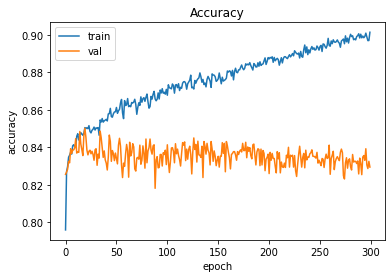

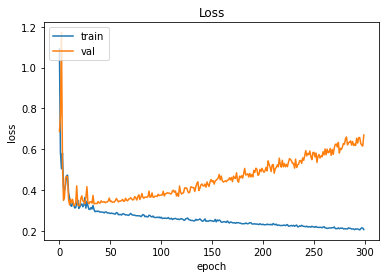

In [166]:
# 시각화
plt.plot(history.history['accuracy']) # train acc
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) # train acc
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [167]:
y_val_predict = np.rint(model.predict(X_val)).astype(int)

precision_recall_fscore_support(y_val, y_val_predict, average='micro')[2]

0.8293666026871401

In [ ]:
y_test_predict = np.rint(model.predict(X_test)).astype(int)

sample_submission['prediction'] = y_test_predict
sample_submission.to_csv('submission_dl_ysk2.csv', index=False)